# Матчинг товаров для Самоката

Даны некоторые векторные представления продуктов(природа векторов неизвестна), которые хранятся в базе данных(base). Запрос (query) представляет из себя набор конкретных продуктов, для которых необходимо найти соответствие в базе данных.

Так же в распоряжении train датасет в котором хранятся вектора запросов и точные матчи из base по этим продуктам. 

Необходимо предложить 10 наиболее релевантных кандидатов на матчинг из базы данных для всех товаров из test. Резульатат оценивается метрикой RECALL@10.

Установка faiss для поиска

In [1]:
!pip install faiss-cpu --no-cache --quiet

Установка библиотек, настройка параметров

In [2]:
import faiss
from scipy.spatial import distance as d
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

import multiprocessing
N_CPUS = multiprocessing.cpu_count()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,20)}, style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Настройки для faiss

In [46]:
NLIST = 1000
DISBALANCE_RATE = 4
N_CANDIDATES=500
NPROBE = 32

Загрузка данных

In [4]:
%%time
base = pd.read_csv('/kaggle/input/samokattechworkshop/base.csv')
train = pd.read_csv('/kaggle/input/samokattechworkshop/train.csv')
test = pd.read_csv('/kaggle/input/samokattechworkshop/test.csv')

CPU times: user 56.2 s, sys: 5.16 s, total: 1min 1s
Wall time: 1min 23s


Посмотрим как распределены признаки

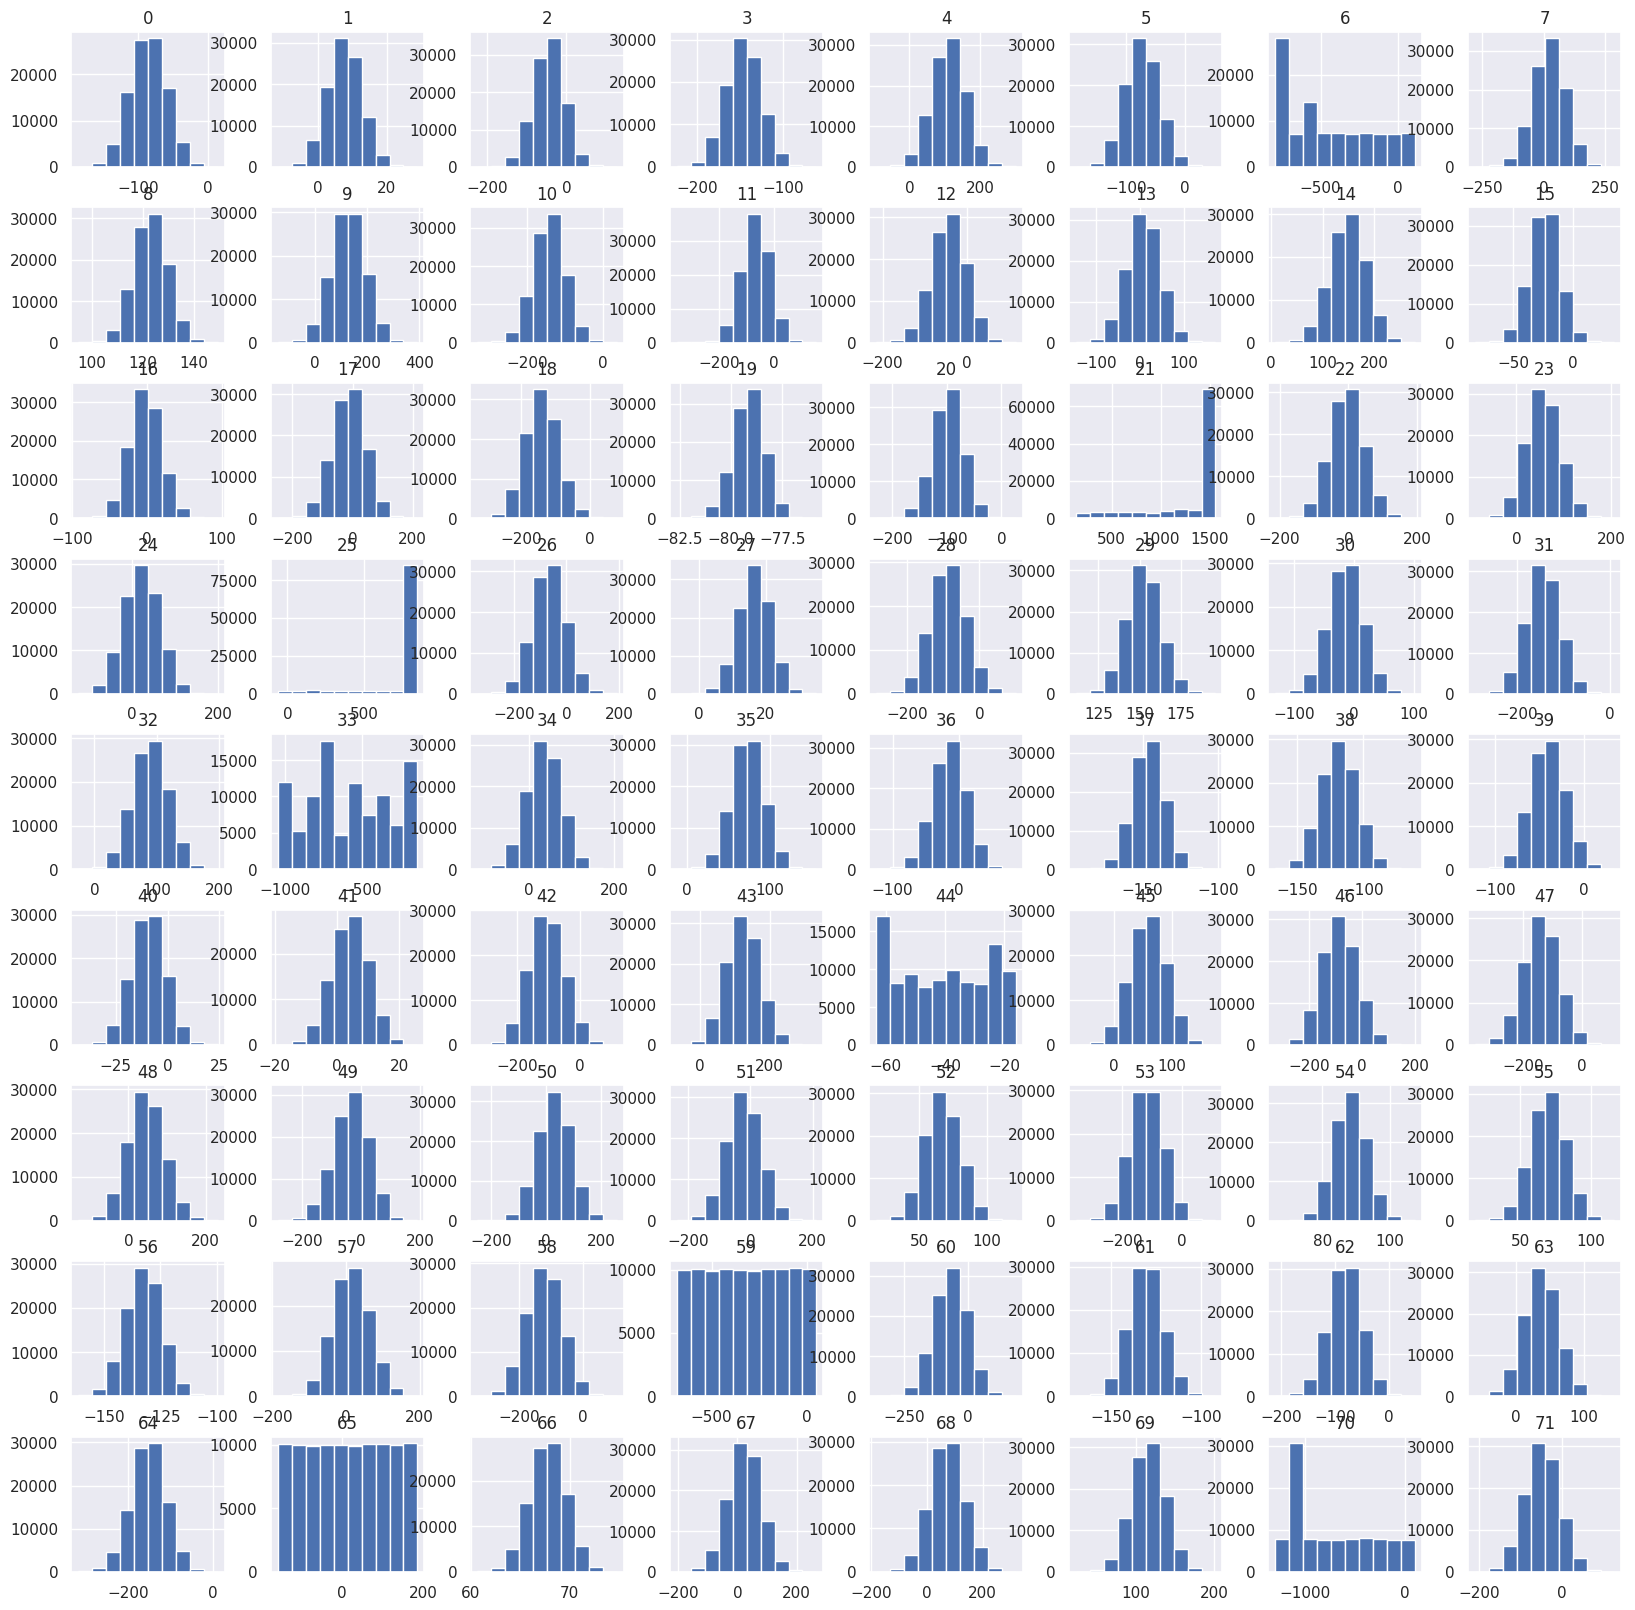

In [5]:
train.hist();

Мы видим что некоторые признаки имеют очень подозрительное распределение. Возможно, это какая-то ошибка при создании эмбеддингов.

Откинем эти признаки из всех датасетов

In [7]:
bad_features = [6,21,25,33,44,59,70,65]
bad_features = list(map(str, bad_features))

base = base.drop(bad_features, axis=1)
train = train.drop(bad_features, axis=1)
test = test.drop(bad_features, axis=1)

Все признаки товаров переведем в numpy array и создадим так же пару query_arr и target_arr соответствующих товаров запросов и промеченных матчей из train

In [8]:
base_arr = base.drop('Id', axis=1).values
base_dict = {k:v for k,v in zip(base.Id, base_arr)}
target_arr = np.array([base_dict[i] for i in train.Target])
query_arr = train.drop(['Id', 'Target'], axis=1).values
test_arr = test.drop('Id', axis=1).values

Нормализуем все вектора

In [9]:
def normalize(arr):
    return arr / np.linalg.norm(arr, axis=1, keepdims=True)

base_arr_norm = normalize(base_arr)
test_arr_norm = normalize(test_arr)
query_arr_norm = normalize(query_arr)
target_arr_norm = normalize(target_arr)

Создадим индекс faiss с соответствующими настройками

In [10]:
%%time
dim = base_arr_norm.shape[1]
quantizer = faiss.IndexFlatIP(dim) 
index = faiss.IndexIVFFlat(quantizer, dim, NLIST)
assert not index.is_trained
index.train(base_arr_norm)
assert index.is_trained
index.add(base_arr_norm)
index.nprobe = NPROBE

CPU times: user 1min 23s, sys: 1.92 s, total: 1min 25s
Wall time: 23.8 s


Проверим как хорошо работает поиск: для каждого товара из query возьмем топ N_CANDIDATES похожих из base и посмотрим есть ли в этом списке матч из target

In [49]:
r = []
for i,query in tqdm(enumerate(query_arr_norm)):
    _, I = index.search(np.expand_dims(query,axis=0), N_CANDIDATES)
    r.append(train.Target[i] in base.Id[I[0]].values)
    if i==5000:
        break
np.mean(r)

5000it [00:46, 107.55it/s]


0.8160367926414717

То есть в 81% случаев в N_CANDIDATES есть наш искомый матч.

## Обучение классификатора для ранжирования результатов поиска

Функция считает разные расстояния между векторами query и target 

In [12]:
def get_distances_list(u:np.array, v:np.array) -> list:
    distances = [
        d.braycurtis(u,v),
        d.canberra(u,v),
        d.chebyshev(u,v),
        d.cityblock(u,v),
        d.correlation(u,v),
        d.cosine(u,v),
        d.euclidean(u,v),
        d.minkowski(u,v,3),
        d.minkowski(u,v,5)
    ]
    return distances

Сначала посчитаем расстояния для всех известных матчей из train, у них будет метка "1".

In [13]:
# matched items
distances = []

for u,v in tqdm(zip(query_arr_norm,target_arr_norm)):
    curr_dist = get_distances_list(u,v)
    curr_dist.append(1)
    distances.append(curr_dist)
    

100000it [00:32, 3122.41it/s]


Теперь возьмем в DISBALANCE_RATE раз больше случайных товаров из base и посчитаем расстояния для них. Это нужно для того чтобы модель обучалась на данных приближенных к результатам поиска, предполагая, что не матчей больше чем потенциальных матчей. Эти объекты будут с меткой "0" так как мы знаем что в base лежат уникальные товары и там нет матчей.

In [14]:
# random samples - unmatched

random_idxs_1 = np.random.randint(0, len(base_arr_norm), len(train)*DISBALANCE_RATE)
random_idxs_2 = np.random.randint(0, len(base_arr_norm), len(train)*DISBALANCE_RATE)

random_base_1, random_base_2= base_arr_norm[random_idxs_1], base_arr_norm[random_idxs_2]

distances_unm = []

for u,v in tqdm(zip(random_base_1,random_base_2)):
    curr_dist = get_distances_list(u,v)
    curr_dist.append(0)
    distances_unm.append(curr_dist)

400000it [02:01, 3291.92it/s]


Теперь объединим все в один датасет для обучения классификатора

In [15]:
columns = ['braycurtis', 
           'canberra', 
           'chebyshev', 
           'citiblock', 
           'corr', 
           'cosine', 
           'euclidean', 
           'minkowski_3', 
           'minkowski_5', 
           'match']
df = pd.DataFrame(distances + distances_unm, columns = columns)
df

,braycurtis,canberra,chebyshev,citiblock,corr,cosine,euclidean,minkowski_3,minkowski_5,match
0,0.063754,7.847181,0.094636,0.840636,1.233098e-02,1.202332e-02,0.155070,0.107969,0.095856,1
1,0.181017,17.399914,0.157951,2.371954,8.712761e-02,8.566629e-02,0.413923,0.255162,0.187161,1
2,0.075077,10.732964,0.057177,0.973100,1.389723e-02,1.388420e-02,0.166639,0.102450,0.075174,1
3,0.077916,10.410487,0.077066,1.035601,1.602571e-02,1.609455e-02,0.179413,0.111674,0.086047,1
4,0.000027,0.004449,0.000027,0.000356,2.443337e-09,2.458369e-09,0.000070,0.000045,0.000034,1
...,...,...,...,...,...,...,...,...,...,...
499995,0.197025,19.722568,0.222583,2.546153,1.071082e-01,1.050013e-01,0.458260,0.294425,0.235483,0
499996,0.262199,21.687272,0.254230,3.245366,1.752904e-01,1.722275e-01,0.586903,0.370669,0.282326,0
499997,0.324651,26.995820,0.202057,3.970163,2.278791e-01,2.314957e-01,0.680435,0.407111,0.283988,0
499998,0.187912,18.842488,0.185522,2.426396,1.017433e-01,9.958135e-02,0.446276,0.283750,0.214824,0


Посмотрим как отличаются расстояния для объектов разных классов

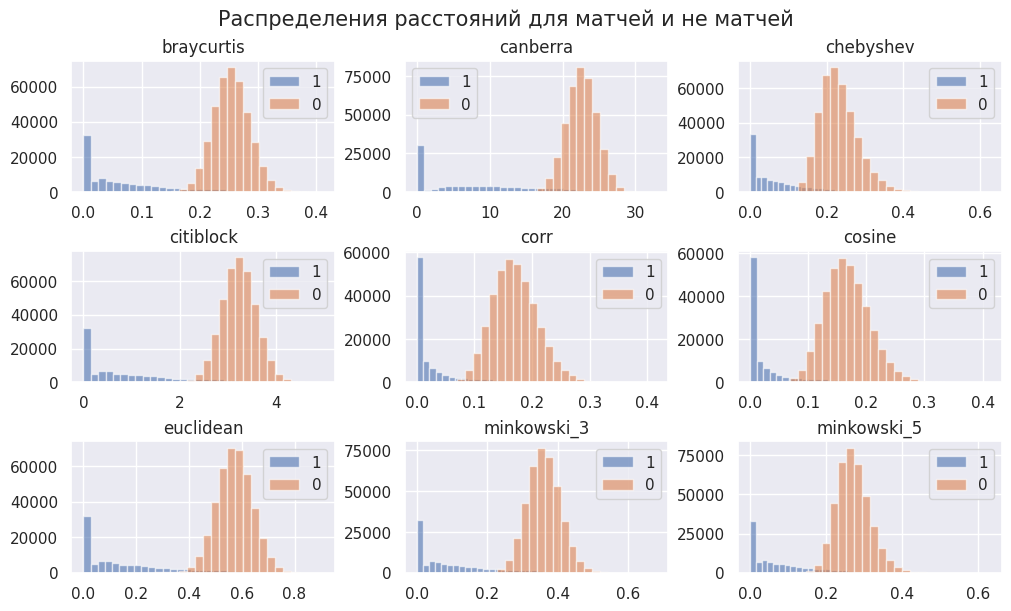

In [43]:
fig = plt.figure(figsize=(10,6), constrained_layout=True)
for k, col in enumerate(df.drop('match', axis=1).columns):
    plt.subplot(3, 3, k+1)
    plt.title(col)
    df[df.match==1][col].hist(bins=30,alpha=0.6,label='1')
    df[df.match==0][col].hist(bins=30,alpha=0.6, label='0')
    plt.legend()
    plt.xlabel('')
fig.subplots_adjust(hspace=0.4, top=0.92)
fig.suptitle('Распределения расстояний для матчей и не матчей', fontsize=15)
plt.show()

Из гистограмм видно что по этим признакам можно довольно точно разделять классы.

Берем логистическую регрессию так как признаки у нас однородные и можно разделить классы линейно и плюс нам важна скорость работы(нужно посчитать для 100 тысяч запросов из test). Веса классов зададим для максимизации recall - нам нужно как можно больше найти потенциальных кандидатов для матчинга. 

In [18]:
%%time
X = df.drop('match', axis=1).values
y = df.match.values

clf = LogisticRegression(max_iter=1000, 
                         #class_weight='balanced',
                         class_weight={0:1, 1:DISBALANCE_RATE+1},
                         C=2,
                         n_jobs=-1)

cv_scores = cross_validate(
    clf, 
    X, y, 
    cv=5, 
    n_jobs=-1,
    scoring=('f1', 'recall', 'precision', 'roc_auc')
    )

print('f1', cv_scores['test_f1'].mean())
print('precision', cv_scores['test_precision'].mean())
print('recall', cv_scores['test_recall'].mean())
print('roc auc', cv_scores['test_roc_auc'].mean())

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


f1 0.9010964125857855
precision 0.8912114655460585
recall 0.91121
roc auc 0.9747673228125
CPU times: user 108 ms, sys: 60.3 ms, total: 168 ms
Wall time: 8.64 s


Модель показывает довольно неплохой результат на кросс-валидации. Удается идентифицировать 91% из всех матчей. Обучим классификатор на всех данных:

In [17]:
clf.fit(X,y)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


LogisticRegression(C=2, class_weight={0: 1, 1: 5}, max_iter=1000, n_jobs=-1)

## Candidates extraction

Функция create_features будет создавать матрицу признаков для всех кандидатов на ранжирование.  
Функция get_candidates ранжирует кандидатов на основании скоров классификатора и берет топ-10 с наивысшими скорами.

In [30]:
base_ids = dict(base.Id)

def create_features(candidates: np.array, query:np.array) -> np.array:

    distances_candidates = []
    for candidate in candidates:
        distances_candidates.append(get_distances_list(candidate, query))
    
    return np.array(distances_candidates)


def get_candidates(query:np.array, n_candidates:int=N_CANDIDATES) -> str:
    
    _, I = index.search(np.expand_dims(query,axis=0), n_candidates)
    candidates = base_arr_norm[I[0]]
    X_candidates = create_features(candidates, query)
    y_hat = clf.predict_proba(X_candidates)[:,1]
    idxs = pd.Series(y_hat, index=I[0]).sort_values(ascending=False).head(10).index
    
    return ' '.join([base_ids[id] for id in idxs])

Посчитаем топ-10 кандидатов для всех товаров из test

In [31]:
%%time
res = []
pool = multiprocessing.Pool(N_CPUS)
for _, result in tqdm(enumerate(pool.imap(get_candidates, test_arr_norm))):
    res.append(result)
    
pool.close()

100000it [1:32:17, 18.06it/s]

CPU times: user 8min 32s, sys: 57.4 s, total: 9min 29s
Wall time: 1h 32min 17s


Результат для сабмита на kaggle

In [32]:
submit = pd.DataFrame(test.Id)
submit['Predicted'] = res
submit.to_csv('samokat_submit.csv', index=False)
submit.head()

,Id,Predicted
0,100000-query,508555-base 3209652-base 399677-base 3839597-b...
1,100001-query,2666508-base 163485-base 1000521-base 11853-ba...
2,100002-query,472256-base 496010-base 153272-base 25113-base...
3,100003-query,3168654-base 1831175-base 2345993-base 4473809...
4,100004-query,1217188-base 75484-base 2366033-base 2411488-b...


Результат на лидерборде 0.719